Based on 
* https://github.com/huggingface/notebooks/blob/main/examples/question_answering.ipynb
* https://www.sbert.net/docs/usage/semantic_textual_similarity.html


---



Embedding - key for efficient transfer learning that widely used last times. Sentence Embedding allow to encode texts of any length to vectors that will contains a lot of information for future works. 

In [ ]:
!nvidia-smi

Fri Apr 21 13:54:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install -U sentence-transformers datasets transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sentence_transformers import SentenceTransformer, util

# Two lists of sentences
sentences1 = [
    'The cat sits outside',
    'A man is playing guitar',
    'The new movie is awesome',
    'Новый фильм очень крутой',
    'Этот текст описывает современное искусство',
  ]

sentences2 = [
    'The dog plays in the garden',
    'A woman watches TV',
    'The new movie is so great',
    'The new movie is so cool',
    'Lets talk about language agnostic sentence encoding like LaBSE',
]

def evaluate_model(model, sentences1, sentences2):
  #Compute embedding for both lists
  embeddings1 = model.encode(sentences1, convert_to_tensor=True)
  embeddings2 = model.encode(sentences2, convert_to_tensor=True)

  #Compute cosine-similarities
  cosine_scores = util.cos_sim(embeddings1, embeddings2)

  #Output the pairs with their score
  for i in range(len(sentences1)):
      print(f"{sentences1[i]:50} {sentences2[i]:70} Score: {cosine_scores[i][i]:.4f}")


BERT trained only on English, it's ok, but how can we solve multilangiage problem? 

In [ ]:
evaluate_model(
    SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2'),
    sentences1,
    sentences2,
)

The cat sits outside                               The dog plays in the garden                                            Score: 0.2733
A man is playing guitar                            A woman watches TV                                                     Score: -0.0123
The new movie is awesome                           The new movie is so great                                              Score: 0.8913
Новый фильм очень крутой                           The new movie is so cool                                               Score: -0.0158
Этот текст описывает современное искусство         Lets talk about language agnostic sentence encoding like LaBSE         Score: 0.0137


In [ ]:
evaluate_model(
    SentenceTransformer('sentence-transformers/LaBSE'),
    sentences1,
    sentences2,
)

The cat sits outside                               The dog plays in the garden                                            Score: 0.6546
A man is playing guitar                            A woman watches TV                                                     Score: 0.4668
The new movie is awesome                           The new movie is so great                                              Score: 0.9434
Новый фильм очень крутой                           The new movie is so cool                                               Score: 0.9086
Этот текст описывает современное искусство         Lets talk about language agnostic sentence encoding like LaBSE         Score: 0.1525


# Question Answering

In [ ]:
from datasets import load_dataset, load_metric
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

from transformers import AutoTokenizer
import transformers
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer


model_checkpoint = "sentence-transformers/all-MiniLM-L6-v2"
batch_size = 16

In [ ]:
dataset = load_dataset("squad_v2")
dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

In [ ]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

show_random_elements(dataset["train"])

,id,title,context,question,answers
0,5a1f6f6654a786001a36b2bd,Videoconferencing,"VRS services have become well developed nationally in Sweden since 1997 and also in the United States since the first decade of the 2000s. With the exception of Sweden, VRS has been provided in Europe for only a few years since the mid-2000s, and as of 2010 has not been made available in many European Union countries, with most European countries still lacking the legislation or the financing for large-scale VRS services, and to provide the necessary telecommunication equipment to deaf users. Germany and the Nordic countries are among the other leaders in Europe, while the United States is another world leader in the provisioning of VRS services.",What has become developed in Germany since 1997?,"{'text': [], 'answer_start': []}"
1,572f7d6f04bcaa1900d76a19,Hyderabad,"Hyderabad has a tropical wet and dry climate (Köppen Aw) bordering on a hot semi-arid climate (Köppen BSh). The annual mean temperature is 26.6 °C (79.9 °F); monthly mean temperatures are 21–33 °C (70–91 °F). Summers (March–June) are hot and humid, with average highs in the mid-to-high 30s Celsius; maximum temperatures often exceed 40 °C (104 °F) between April and June. The coolest temperatures occur in December and January, when the lowest temperature occasionally dips to 10 °C (50 °F). May is the hottest month, when daily temperatures range from 26 to 39 °C (79–102 °F); December, the coldest, has temperatures varying from 14.5 to 28 °C (57–82 °F).",What is the mean yearly temperature in Hyderabad in Celsius?,"{'text': ['26.6 °C'], 'answer_start': [139]}"
2,5728dbd84b864d1900164fab,Paris,"According to Eurostat, the EU statistical agency, in 2012 the Commune of Paris was the most densely populated city in the European Union, with 21,616 people per square kilometre within the city limits (the NUTS-3 statistical area), ahead of Inner London West, which had 10,374 people per square kilometre. According to the same census, three departments bordering Paris, Hauts-de-Seine, Seine-Saint-Denis and Val-de-Marne, had population densities of over ten thousand people per square kilometre, ranking among the ten most densely populated areas of the EU.",How many people lived per square kilometer in the city limits?,"{'text': ['21,616'], 'answer_start': [143]}"
3,56f83111aef2371900625ed9,Szlachta,"For many centuries, wealthy and powerful members of the szlachta sought to gain legal privileges over their peers. Few szlachta were wealthy enough to be known as magnates (karmazyni—the ""Crimsons"", from the crimson colour of their boots). A proper magnate should be able to trace noble ancestors back for many generations and own at least 20 villages or estates. He should also hold a major office in the Commonwealth.",What did powerful leaders of szlachta sought?,"{'text': ['gain legal privileges over their peers'], 'answer_start': [75]}"
4,5733eb23d058e614000b65c6,Premier_League,"The Football Association Premier League Ltd (FAPL) is operated as a corporation and is owned by the 20 member clubs. Each club is a shareholder, with one vote each on issues such as rule changes and contracts. The clubs elect a chairman, chief executive, and board of directors to oversee the daily operations of the league. The current chairman is Sir Dave Richards, who was appointed in April 1999, and the chief executive is Richard Scudamore, appointed in November 1999. The former chairman and chief executive, John Quinton and Peter Leaver, were forced to resign in March 1999 after awarding consultancy contracts to former Sky executives Sam Chisholm and David Chance. The Football Association is not directly involved in the day-to-day operations of the Premier League, but has veto power as a special shareholder during the election of the chairman and chief executive and when new rules are adopted by the league.",Who is the current CEO of the Premier League?,"{'text': ['Richard Scudamore'], 'answer_start': [428]}"
5,5731d073b9d445

## Preprocessing

We instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

we get a tokenizer that corresponds to the model architecture we want to use,
we download the vocabulary used when pretraining this specific checkpoint.
That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [ ]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

One specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`:

In [ ]:
for i, example in enumerate(dataset["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > max_length:
        break
example = dataset["train"][i]

print(
    "Without any truncation, we get the following length for the input IDs:",
    len(tokenizer(example["question"], example["context"])["input_ids"])
)

print(
    "Now, if we just truncate, we will lose information (and possibly the answer to our question):",
    len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])
)

Without any truncation, we get the following length for the input IDs: 437
Now, if we just truncate, we will lose information (and possibly the answer to our question): 384


Note that we never want to truncate the question, only the context, else the only_second truncation picked. Now, our tokenizer can automatically return us a list of features capped by a certain maximum length, with the overlap we talked above, we just have to tell it with `return_overflowing_tokens=True` and by passing the stride:

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)


print(
    "Now we don't have one list of input_ids, but several:",
    [len(x) for x in tokenized_example["input_ids"]]
)

Now we don't have one list of input_ids, but several: [384, 192]


In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] beyonce got married in 2008 to whom? [SEP] on april 4, 2008, beyonce married jay z. she publicly revealed their marriage in a video montage at the listening party for her third studio album, i am... sasha fierce, in manhattan's sony club on october 22, 2008. i am... sasha fierce was released on november 18, 2008 in the united states. the album formally introduces beyonce's alter ego sasha fierce, conceived during the making of her 2003 single " crazy in love ", selling 482, 000 copies in its first week, debuting atop the billboard 200, and giving beyonce her third consecutive number - one album in the us. the album featured the number - one song " single ladies ( put a ring on it ) " and the top - five songs " if i were a boy " and " halo ". achieving the accomplishment of becoming her longest - running hot 100 single in her career, " halo "'s success in the us helped beyonce attain more top - ten singles on the list than any other woman during the 2000s. it also included the suc

Now this will give us some work to properly treat the answers: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an `offset_mapping`:

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:20])

[(0, 0), (0, 7), (8, 11), (12, 19), (20, 22), (23, 27), (28, 30), (31, 35), (35, 36), (0, 0), (0, 2), (3, 8), (9, 10), (10, 11), (12, 16), (16, 17), (18, 25), (26, 33), (34, 37), (38, 39)]


This gives, for each index of our input IDS, the corresponding start and end character in the original text that gave our token. The very first token ([CLS]) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question:

In [ ]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

beyonce Beyonce


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

It returns None for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

Now let's put everything together in one function we will apply to our training set. In the case of impossible answers (the answer is in another feature given by an example with a long context), we set the cls index for both the start and end position. We could also simply discard those examples from the training set if the flag `allow_impossible_answers` is False. Since the preprocessing is already complex enough as it is, we've kept is simple for this part.

In [ ]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
tokenized_datasets = dataset.map(prepare_train_features, batched=True, remove_columns=dataset["train"].column_names)

### Fine-tuning the model

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elemen

In [ ]:
for name, param in model.named_parameters():
  if 'qa_outputs' not in name:
    param.requires_grad = False

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-4)
lr_scheduler = transformers.get_scheduler(
    name="constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=5000,
)

We will use Learning rate like on this image

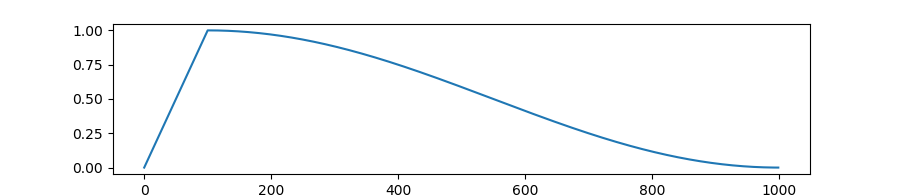

In [ ]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squad",
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    max_steps=7500,
    eval_steps=2500,
)
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    optimizers=(optimizer, lr_scheduler)
)

trainer.train()

Step,Training Loss,Validation Loss
2500,3.891800,3.335956
5000,3.902900,3.320937


TrainOutput(global_step=5000, training_loss=4.0526876953125, metrics={'train_runtime': 571.6921, 'train_samples_per_second': 139.935, 'train_steps_per_second': 8.746, 'total_flos': 1962698711040000.0, 'train_loss': 4.0526876953125, 'epoch': 0.61})

### Evaluation

In [ ]:
import torch

for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

The output of the model is a dict-like object that contains the loss (since we provided labels), the start and end logits. We won't need the loss for our predictions, let's have a look a the logits:

In [ ]:
output.start_logits.shape, output.end_logits.shape

In [ ]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call n_best_size. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one. Here is how we would do this on the first feature in the batch:

In [ ]:
import numpy as np


n_best_size = 20

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

And then we can sort the valid_answers according to their score and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:

* the ID of the example that generated the feature (since each example can generate several features, as seen before);
* the offset mapping that will give us a map from token indices to character positions in the context.

That's why we will re-process the validation set with the following function, slightly different from `prepare_train_features`:

In [ ]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [ ]:
validation_features = dataset["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=dataset["validation"].column_names
)

In [ ]:
raw_predictions = trainer.predict(validation_features)

In [ ]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = dataset["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > 30:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers, dataset["validation"][0]["answers"]